In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns  

In [2]:
from sklearn.datasets import fetch_openml

# Загружаем данные из https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', return_X_y = True, as_frame = False)

In [3]:
N, d = X.shape
N, d #70000 цифр, 784 - картинка из 28*28 пискелей

(70000, 784)

In [4]:
def draw_digit(Img, digit):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(Img, (28, 28))) #Выводим написанное число
    plt.text(0, 27, str(digit), color = 'b') #Выводим маленькое число в левом нижнем углу
    plt.set_cmap('binary')  

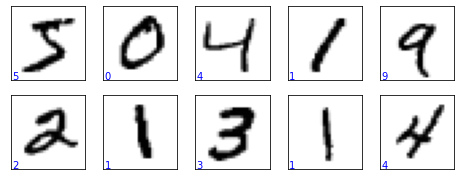

In [5]:
plt.figure(figsize = (8, 3)) 
for i in range(10):
    plt.subplot(2, 5, i+1) #Выводим 2 строчки по 5 картинок
    draw_digit(X[i, :], y[i])

# 1. Метод главных компонент

In [6]:
Xtest = X[0:5000]
Ytest = y[0:5000]

In [7]:
Xtest.shape

(5000, 784)

In [8]:
Ytest.shape

(5000,)

In [9]:
from sklearn.decomposition import PCA

In [10]:
pca = PCA(n_components=2)
pca.fit(Xtest, Ytest)

PCA(n_components=2)

In [11]:
print(pca.explained_variance_ratio_)

[0.09867566 0.07404546]


Доля объясняненной дисперсии при использовании 2 главных компонент очень маленькая


In [12]:
principalComponents = pca.fit_transform(Xtest)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['P1', 'P2'])

In [13]:
principalDf.insert(2, "Ytest", Ytest)

In [14]:
principalDf

,P1,P2,Ytest
0,116.147411,368.858924,5
1,1037.282310,386.497952,0
2,-28.452291,-453.367314,4
3,-877.069059,596.112548,1
4,-357.768110,-687.251755,9
...,...,...,...
4995,-370.185086,-648.690465,7
4996,357.876761,949.093209,3
4997,474.480023,181.306720,2
4998,-850.333901,255.451624,1


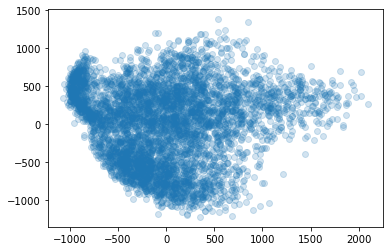

In [15]:
plt.scatter(principalDf['P1'], principalDf['P2'], alpha=0.2)

<AxesSubplot:xlabel='P1', ylabel='P2'>

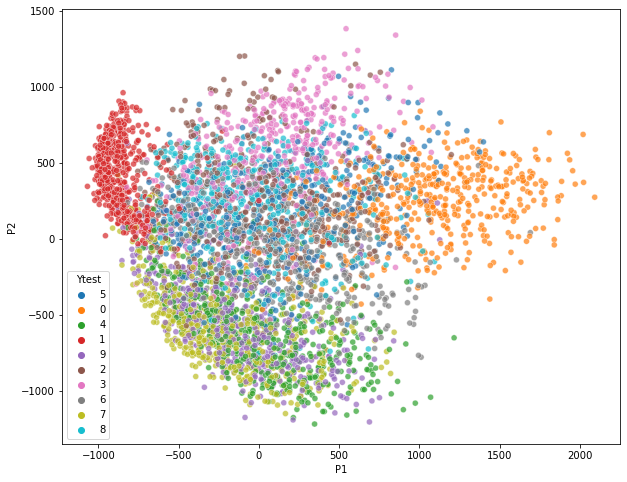

In [16]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x=principalDf['P1'], y=principalDf['P2'], hue=principalDf['Ytest'], alpha=0.7)

Обратим внимание, что при использовании 2 ГК некоторые классы очень даже хорошо отделимы друг от друга, к примеру класс 0 или 1, однако остальные классы смешиваются. Такое поведение наблюдается из-за того что 2 ГК не хватает, доля объясненной диспрессии маленькая

# 2. Нелинейное понижение размерности

Будем применять разные методы понижения размерности и затем применять метод кластеризации BIRCH, который показывал лучший результат RI в прошлой работе

In [164]:
from sklearn.manifold import Isomap
from sklearn import metrics
from sklearn.cluster import Birch

In [165]:
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(Xtest)
X_transformed.shape

(5000, 2)

In [166]:
model1 = Birch(n_clusters = 10)
model1.fit(X_transformed.data)
Birch(n_clusters = 10)

Birch(n_clusters=10)

In [167]:
all_predictions1 = model1.predict(X_transformed.data)

In [168]:
all_predictions1

array([0, 7, 4, ..., 6, 0, 0], dtype=int64)

In [169]:
metrics.rand_score(Ytest, all_predictions1)

0.842961472294459

При использовании этого метода показатель RI оказался равен примерно 0.843, что довольно неплохо, попробуем увеличить количество компонент

In [170]:
embedding1 = Isomap(n_components=5)
X_transformed1 = embedding1.fit_transform(Xtest)
X_transformed1.shape

(5000, 5)

In [171]:
model2 = Birch(n_clusters = 10)
model2.fit(X_transformed1.data)
Birch(n_clusters = 10)

Birch(n_clusters=10)

In [172]:
all_predictions2 = model2.predict(X_transformed1.data)

In [173]:
all_predictions2

array([7, 5, 2, ..., 3, 3, 3], dtype=int64)

In [174]:
metrics.rand_score(Ytest, all_predictions2)

0.886249649929986

Мы увеличили число компонент до 5, показатель RI стал получше, примерно 0.886, но в идеале хотелось бы найти золотую середину, так как мы не хотим иметь большую размерность после понижения размерности, поэтому можно договориться, что при значении RI скажем не менее 0.9 мы можем принять модель как рабочую

Давайте уменьшим число чисел в Xtest c 5000 до 1000, чтобы уменьшить время вычислений и посчитаем RI для разных значений ГК, скажем от 1 до 20

In [175]:
XTEST = X[0:1000]
YTEST = y[0:1000]
Arr = []
for i in range(1,20,1):
    embedding = Isomap(n_components = i)
    X_transformed = embedding.fit_transform(XTEST)
    X_transformed.shape
    model = Birch(n_clusters = 10)
    model.fit(X_transformed.data)
    Birch(n_clusters = 10)
    all_predictions = model.predict(X_transformed.data)
    Arr.append(metrics.rand_score(YTEST, all_predictions))
Arr

[0.8498278278278278,
 0.8653173173173173,
 0.8587407407407407,
 0.8762842842842843,
 0.8762322322322322,
 0.882988988988989,
 0.8798098098098098,
 0.8756056056056056,
 0.8856576576576577,
 0.9005145145145145,
 0.891981981981982,
 0.8945225225225225,
 0.8889029029029029,
 0.8878578578578579,
 0.8871491491491491,
 0.8898198198198198,
 0.8804664664664664,
 0.8868328328328329,
 0.8876476476476477]

Text(0, 0.5, 'RI')

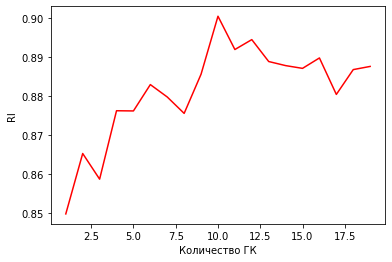

In [176]:
Cnt = range(1,20)
plt.plot(Cnt, Arr, color = 'red')
plt.xlabel('Количество ГК')
plt.ylabel('RI')

Таким образом можем взять 10 ГК, при таком количестве ГК, показатель RI достигает наибольшего значения

Теперь попробуем другой метод понижения размерности

In [187]:
from sklearn.manifold import TSNE
embedding1 = TSNE(n_components=2)
X_transformed1 = embedding1.fit_transform(Xtest)
X_transformed1.shape

C:\Users\kiril\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kiril\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(5000, 2)

In [189]:
model2 = Birch(n_clusters = 10)
model2.fit(X_transformed1.data)

Birch(n_clusters=10)

In [190]:
all_predictions2 = model2.predict(X_transformed1.data)

In [192]:
all_predictions2 

array([9, 4, 8, ..., 0, 0, 0], dtype=int64)

In [193]:
metrics.rand_score(Ytest, all_predictions2)

0.9262878975795159

Данный метод показывает более лучший результат по сравнению с предыдущим для 2 ГК

Посмотрим какой показатель RI будет у моделей с разным чилом ГК от 1 до 20

In [203]:
XTEST = X[0:1000]
YTEST = y[0:1000]
Arr = []
for i in range(1,4,1):
    embedding2 = TSNE(n_components = i)
    X_transformed2 = embedding2.fit_transform(XTEST)
    X_transformed2.shape
    model3 = Birch(n_clusters = 10)
    model3.fit(X_transformed2.data)
    Birch(n_clusters = 10)
    all_predictions3 = model3.predict(X_transformed2.data)
    Arr.append(metrics.rand_score(YTEST, all_predictions3))
Arr

C:\Users\kiril\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kiril\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kiril\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kiril\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kiril\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kiril\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: Future

[0.8806826826826827, 0.8957077077077077, 0.8975355355355356]

В процессе выяснилось, что n_components должно быть меньше 4 для корректной работы метода, поэтому вывели значения для 1 2 и 3 ГК

Показатель RI примерно одинаковый во всех трех случаях, поэтому можно взять модель с минимальным количеством компонент